# Can you hear the size of a reservoir?

**MOD510 - Project 2 G05** 
- Parthasarathi Jena  
- Jing Hou
- Hodjdat Moradi  

Date: Oct.15.2023

In [1]:
# load libraries
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.special import expi
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
import numba as nb

#%matplotlib

# Steady State Solutions

In [2]:
class PressureSolver:
    """
    A finite difference solver to solve pressure distribution in
    a reservoir, logarithmic grid has been used, y = ln(r/rw)
    The solver uses SI units internally, while "practical field units"
    are required as input. For the steady state solution we work with dummy values,
    so for this case we ignore all physical parameter, and set alpha to 1
    and p_init to 1
    
    Input arguments:
        name                                symbol   unit
        --------------------------------------------------------------
        Number of grid points                N       dimensionless
        Well radius                          rw      ft
        Outer reservoir boundary             re      ft
        Initial reservoir pressure           pi      psi
        Laziness                             lazines index takes value (1= not so lazy,2=very lazy)
        -------------------------------------------------------------
    
    """
    def __init__(self,N, 
                 rw=0.318,
                 re=1000.0, 
                 pinit=1.0, 
                 laziness=1):
        #####################################################################
        #####            Physical parameter set up           ################
        #####################################################################
        # Unit conversion factors (input units --> SI)
        self.ft_to_m_ = 0.304
         
        # store the model parameters
        self.N_ = N
        self.rw_ = rw*self.ft_to_m_
        self.re_ = re*self.ft_to_m_
        
        # Initial and boundary conditions
        self.pinit_ = 1 # we just set initial reservior pressure to 1
        
        #####################################################################
        #####                 Model parameter set up         ################
        #####################################################################
        #Grid discretization
        min_ = np.log(self.rw_/self.rw_) # minimum value of y
        max_ = np.log(self.re_/self.rw_)
        self.maxy = max_
        self.dy = (max_-min_)/self.N_   # delta y: grid spatial spacing
        #generate N points between min_ and max_ and shift by delta y/2
        self.y = np.linspace(0, 1, self.N_, endpoint=False) * self.maxy+self.dy/2 
        self.r = self.rw_*np.exp(self.y)
        self.lazy = laziness
                
        #in this model we only requre dummy 'physical parameter' alpha ands 
        # we set it to 1
        self.alpha = 1
                
        #####################################################################
          
    def tri_diag(self,a, b, c, k1=-1, k2=0, k3=1):
        ''' 
        a,b,c diagonal terms
            default k-values for 4x4 matrix:
            | b0 c0 0  0 |
            | a0 b1 c1 0 |
            | 0  a1 b2 c2|
            | 0  0  a2 b3|

        '''
        a1=np.diag(a, k1)
        a2 =np.diag(b, k2)
        a3=np.diag(c, k3)
        return a1 + a2 + a3

    def analytical_steadystate(self,y):
        '''
        returns the analytical solution of
        '''
        return -self.alpha*(np.log(self.re_/self.rw_)-y)+self.pinit_

    def make_equation_steadystate(self):
        '''
        makes the steady state equation for the simplified case
        laziness = 2 very lazy
                 = 1 not so lazy
                 = 0 accurate
        '''
        # initiate diagonals of the A matrix 
        # initiate the diagonals and the RHS values
        a=np.ones(self.N_-1)    # term below the diagonal in A matrix
        b=-2*np.ones(self.N_)   # terms on the diagonal in A matrix
        c=np.ones(self.N_-1)    # terms above the diagonal in A matrix
        self.rhs=np.zeros(self.N_)  #RHS terms initiation
        #print('make eq',a,b,c)
        if self.lazy==2: # very lazy solution
            b[0]=-1
            self.rhs[0]=self.alpha*self.dy
            self.rhs[-1]=-self.pinit_
            self. A=self.tri_diag(a,b,c)
        elif self.lazy==1: # not so lazy solution 
            b[0]=-1
            b[-1]=-3
            self.rhs[0]=self.alpha*self.dy
            self.rhs[-1]=-2*self.pinit_
            self.A=self.tri_diag(a,b,c)

    def solve_steady_state(self):
        self.make_equation_steadystate()
        self.soln = np.linalg.solve(self.A,self.rhs)
        #return(self.soln)
    
    def error(self):
        self()
        ana = self.analytical_steadystate(self.y)
        #print(len(ana), len(self.soln))
        return np.abs(ana-self.soln )
    
    def __call__(self):
        return self.solve_steady_state()
       
   

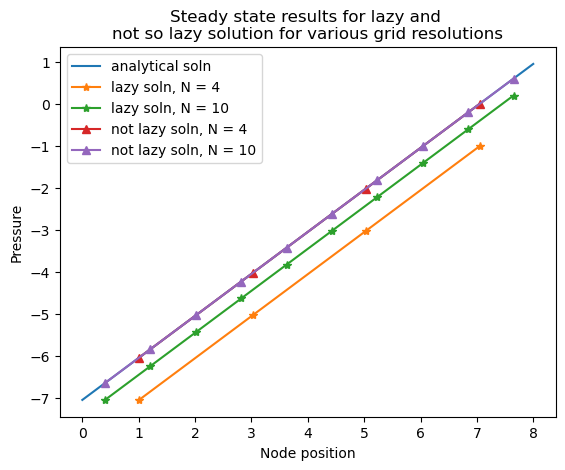

In [3]:
# We attempt to compare the lazy solution and not so lazy solution 
# vs the analytical solution for this simplified case in steady state

#generate models 
lazy4 = PressureSolver(N=4,laziness=2)  # pressure soln with lazy method 4 nodes
lazy10 = PressureSolver(N=10, laziness=2) # pressure soln with lazy method 10 nodes
nslazy4 = PressureSolver(N=4, laziness=1) # pressure soln with not so lazy method 4 nodes
nslazy10 = PressureSolver(N=10, laziness=1) # pressure soln with not so lazy method 10 nodes

# solve all the 4 models above to compute the steady state soln
lazy4(),lazy10(),nslazy4(),nslazy10()     

#analytical soln
y = np.linspace(0,8,100)  # grid for the analytical solution
analytical= PressureSolver(4).analytical_steadystate(y)

# plot comparision plots
fig, ax = plt.subplots()
ax.plot(y, analytical, label= 'analytical soln')
ax.plot(lazy4.y, lazy4.soln,'-*', label='lazy soln, N = 4')
ax.plot(lazy10.y, lazy10.soln,'-*', label='lazy soln, N = 10')
ax.plot(nslazy4.y, nslazy4.soln,'-^', label='not lazy soln, N = 4')
ax.plot(nslazy10.y, nslazy10.soln,'-^', label='not lazy soln, N = 10')

plt.xlabel('Node position')
plt.ylabel('Pressure')
plt.title('Steady state results for lazy and \nnot so lazy solution for various grid resolutions')

plt.legend()
fig.savefig('steady_state_soln.png')

In [4]:
# calulate errors with the lazy solution

errors = []  # array stores error for a given value of N 
dys = []     # array stores delta y for a given value of N 

# To compare errors consistently we are interested
# in comparing error at a fixed y. We do this by dividing the domain into
# odd number of nodes (N is odd) and picking the error at the middle node
Ns = range(5,200,2)
for N in Ns:    
    model = PressureSolver(N, 10, laziness=2)  # make model with N node, very lazy method 
    err = model.error()   # compute error compared to analytical soln
    errors.append(err[N//2]) # pick error in the middle node
    dys.append(model.dy)        #store the delta y for a given N 


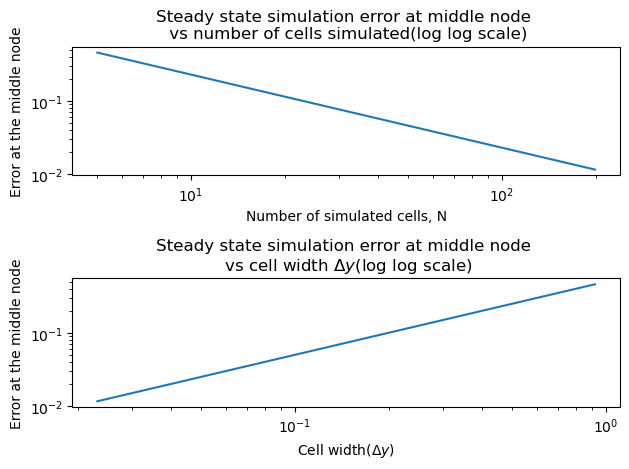

In [5]:
# plot error vs N and error vs dy
fig, axs = plt.subplots(nrows=2)

ax = axs[0]
ax.plot(Ns, errors)
ax.set(xscale='log', yscale='log',
       title=f'Steady state simulation error at middle node'
       + f' \n vs number of cells simulated(log scale)',
       xlabel='Number of simulated cells, N',
       ylabel='Error at the middle node'
       )

ax = axs[1]
ax.plot(dys, errors)
ax.set(xscale='log', yscale='log',
       title=f'Steady state simulation error at middle node'
       + f' \n vs cell width $\Delta y$(log scale)',
       xlabel='Cell width($\Delta y$)',
       ylabel='Error at the middle node'
       )

plt.tight_layout()
plt.savefig('steadystateerror.png')


# Time dependent solution

In [6]:
@nb.jit(nopython=True)
def thomas_algorithm(l, d, u, r):
    """
    Solves a tridiagonal linear system of equations with the Thomas-algorithm.
    The code is based on pseudo-code from the following reference:
    Cheney, E. W., & Kincaid, D. R.
    Numerical mathematics and computing, 7th edition,
    Cengage Learning, 2013.
    IMPORTANT NOTES:
        - This function modifies the contents of the input vectors l, d, u and rhs.
        - For Numba to work properly, we must input NumPy arrays, and not lists.
    :param l: A NumPy array containing the lower diagonal (l[0] is not used).
    :param d: A NumPy array containing the main diagonal.
    :param u: A NumPy array containing the upper diagonal (u[-1] is not used).
    :param r: A NumPy array containing the system right-hand side vector.
    :return: A NumPy array containing the solution vector.
    """
    # Allocate memory for solution
    solution = np.zeros_like(d)
    n = len(solution)
    
    # Forward elimination
    for k in range(1, n):
        xmult = l[k] / d[k-1]
        d[k] = d[k] - xmult*u[k-1]
        r[k] = r[k] - xmult*r[k-1]
    # Back-substitution
    solution[n-1] = r[n-1] / d[n-1]
    for k in range(n-2, -1, -1):
        solution[k] = (r[k]-u[k]*solution[k+1])/d[k]
    return solution

In [7]:
class PressureSolver:
    """
    A finite difference solver to solve pressure distribution in
    a reservoir, logarithmic grid has been used, y = ln(r/rw)
    The solver uses SI units internally, while "practical field units"
    are required as input.

    Input arguments:
        name                                symbol   unit
        --------------------------------------------------------------
        Number of grid points                N       dimensionless
        Timesteps for TD sim                 dt      days
        Well radius                          rw      ft
        Outer reservoir boundary             re      ft
        Height of reservoir                  h       ft
        Absolute permeability                k       mD
        Porosity                             phi     dimensionless
        Fluid viscosity                      mu      mPas (cP)
        Total (rock+fluid) compressibility   ct      1 / psi
        Constant flow rate at well           Q       bbl / day
        Initial reservoir pressure           pi      psi
        Laziness                             lazy    steady state lazy solution
        -------------------------------------------------------------

    """

    def __init__(self, N, 
                 re=1000.0,
                 k=500,
                 pinit=4100.0,
                 rw=0.318,
                 h=11.0,
                 phi=0.25,
                 mu=1.0,
                 ct=7.8e-6,
                 Q=1000.0,
                 laziness=False):
        #####################################################################
        #####            Physical parameter set up           ################
        #####################################################################
        # Unit conversion factors (input units --> SI)
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24.*60.*60.
        self.bbl_to_m3_ = 0.1589873

        # Grid
        self.N_ = N
        self.rw_ = rw*self.ft_to_m_
        self.re_ = re*self.ft_to_m_
        self.h_ = h*self.ft_to_m_

        # Rock and fluid properties
        self.k_ = k*1e-15 / 1.01325  # from Darcy to m^2
        self.phi_ = phi
        self.mu_ = mu*1e-3  # from mPas to Pas
        self.ct_ = ct / self.psi_to_pa_

        # Initial and boundary conditions
        self.Q_ = Q*self.bbl_to_m3_ / self.day_to_sec_
        self.pinit_ = pinit*self.psi_to_pa_
        

        #####################################################################
        #####                 Model parameter set up         ################
        #####################################################################
        # Grid discretization
        min_ = np.log(self.rw_/self.rw_)
        max_ = np.log(self.re_/self.rw_)
        self.maxy = max_  # maximum value of y, @ r_e
        self.dy = (max_-min_)/self.N_    # delta y: grid spatial spacing
        self.y = np.linspace(0, 1, self.N_, endpoint=False) * self.maxy+self.dy/2  # grid spatial coordinates
        #self.y = np.arange(0, max_-self.dy/2, self.dy)+self.dy/2
        self.r = self.rw_*np.exp(self.y)

        # model combined parameters
        self.alpha = self.Q_*self.mu_/(2*np.pi*self.h_*self.k_)
        self.beta = self.alpha*self.dy
        # hydraulic diffusivity
        self.eta = self.k_/(self.mu_*self.phi_*self.ct_)
        # xi is dependent on the time step and the position of the node
        # so it will be calculated at the time of building the the matrix
        #####################################################################

    def analytical_steadystate(self, y):
        '''
        returns the analytical solution of well steady state well pressure 
        '''
        return -self.alpha*(np.log(self.re_/self.rw_)-y)+self.pinit_
    
    def tri_diag(self, a, b, c, k1=-1, k2=0, k3=1):
        ''' 
        a,b,c diagonal terms
            default k-values for 4x4 matrix:
            | b0 c0 0  0 |
            | a0 b1 c1 0 |
            | 0  a1 b2 c2|
            | 0  0  a2 b3|

        '''
        a1 = np.diag(a, k1)
        a2 = np.diag(b, k2)
        a3 = np.diag(c, k3)
        return a1 + a2 + a3

    def make_equations(self, deltaT):
        '''
        creates the A matrix and the 'd' array for RHS for the time 
        dependant solution 
        deltaT: the time by which the clock is moving forward, in seconds
        '''
        # create xi scalar along the gridpoints, for a time step of deltaT
        xi = self.eta/self.rw_**2/self.dy**2*np.exp(-2*self.y)*deltaT

        # initiate diagonals of the A matrix and d array
        # initiate the diagonals and the RHS values
        a = -xi[1:]  # term below the diagonal
        b = 1+2*xi   # terms on the diagonal
        c = -xi[:-1]  # terms above the diagonal
        d = np.zeros(self.N_)

        # modify the elements of main diagonal
        # and the RHS for applying boundary conditions
        b[0] -= xi[0]
        b[-1] += xi[-1]
        d[0] = -self.beta*xi[0]
        d[-1] = 2*self.pinit_*xi[-1]
        
        #create sparce matrix A and store d matrix
        self.A = self.tri_diag(a, b, c)
        self.rhs_d = d 
        
    def solve_timedep(self,deltaT,pn, solver='numpy'):
        '''
        Makes the matrix for time dependent solution and then solves for pressure
        Can use several solvers
        Takes:
        pn = the pressure at the current time step, array-like, in Pascals
        deltaT: the time by which the clock is moving forward, scalar, in seconds
        
        Returns pn1 = the pressure at the next time step, array-like Pascals
        '''
        self.make_equations(deltaT)
        rhs = pn+self.rhs_d
        if solver == 'numpy':
            pn1 = np.linalg.solve(self.A, pn+self.rhs_d)
        elif solver == 'scipy':
            A = csc_matrix(self.A)
            #rhs = csc_matrix(rhs)
            pn1 = spsolve(A, rhs)
        elif solver == 'thomas_the_tank':
            # make a copy of A matrix and  calculated RHS and pass to thomas algo
            A = self.A.copy()
            l = np.append([0],np.diag(A,-1)) 
            d = np.array(np.diag(A,0)) 
            u = np.append(np.diag(A,1),[0]) 
            r = rhs.copy()
            
            #print(l,d,u,r)
            #print(d.flags)
            pn1 = thomas_algorithm(l,d,u,r)
        else:
            print('NOT IMPLEMENTED')
            pn1 = None # break things 
        return(pn1)
    
    def timedomainsim(self,deltaTs,solver='numpy'):
        '''
        Performs time domain simulation. 
        It is assumed that the initial pressure at time = 0 is uniformly p_init
        for all y_i
        input: deltaTs = time steps over which sim is to be performed, array-like 
                         in Days
        output:
        simtime: timestamp of the simulation stage(cumulative sum of deltaTs), 
                 array-like, in days
        internal_pressure : the internal pressure at each node at each timestep,
                            2D array of size (len(deltaTs), N)
                            in psi
        '''
        #convert deltaTs from days to seconds 
        deltaTs = np.array(deltaTs)*self.day_to_sec_
        
        #generate simtime
        simtime=[0]   #start at zero seconds
        for dt in deltaTs: simtime.append(simtime[-1]+dt) 
        
        
        # at timestep 0 set the initial pressure at time = 0 is uniformly p_init
        # for all y_i
        p0 = np.ones(self.N_)*self.pinit_
        #print(p0, self.pinit_)
        #save first pressure distrbution
        internal_pressure = [p0]
        
        # start the simulations
        
        for deltaT in deltaTs:
            p_old = internal_pressure[-1] # pressure at the present time
            p_new = self.solve_timedep(deltaT, p_old, solver = solver) #compute the pressures at this timestep
            internal_pressure.append(p_new)
        internal_pressure = np.array(internal_pressure)
        # save sim time and simulated pressure time series in the model
        # units are SI units
        self.simtime_ = simtime
        self.internal_pressure_= internal_pressure
        
        # convert internal pressures to psi 
        simtime=np.array(simtime)/self.day_to_sec_
        internal_pressure = internal_pressure/self.psi_to_pa_
        return (simtime, internal_pressure)
    
    def wellperssure(self,deltaTs):
        #prepare the time series for the 
        self.timedomainsim(deltaTs)
        
        #lets extract the pressure at the well head 
        p0 = self.internal_pressure_[:,0]
        #print(p0)
        
        well_pressure_ = p0-self.beta/2 #SELF EXPLANATORY!
        #rint(well_pressure_)
        return(well_pressure_[1:]/self.psi_to_pa_)
    
    def line_source_soln(self,r,t):
        '''
        calculates the pressure at distance r and time t using the 
        Line Source solution. Q*mu/(2*pi*k*h) = alpha
        
        input: SI units
        r : radius at which pressure is to be calculated,
        t: time at which pressure is to be calculated
        
        returns :
        p = pressure at distance r and time t, in stupid units
        
        '''
        p = self.pinit_ + self.alpha/2*expi(-r**2/4/self.eta/t)
        return(p/self.psi_to_pa_)
        
        

In [8]:
# We will test to see if our implementation of the model 
# generates the correct A matrix for given input parameters
model = PressureSolver(4)
model.make_equations(0.01*model.day_to_sec_)
list(model.A)

[array([ 5287.02460244, -5286.02460244,     0.        ,     0.        ]),
 array([-94.26332181, 189.52664362, -94.26332181,   0.        ]),
 array([ 0.        , -1.68095582,  4.36191165, -1.68095582]),
 array([ 0.        ,  0.        , -0.02997574,  1.08992721])]

Estimate of the pressure wave to reach the outer border  13311.66 secs =3.70 hours =0.15 days


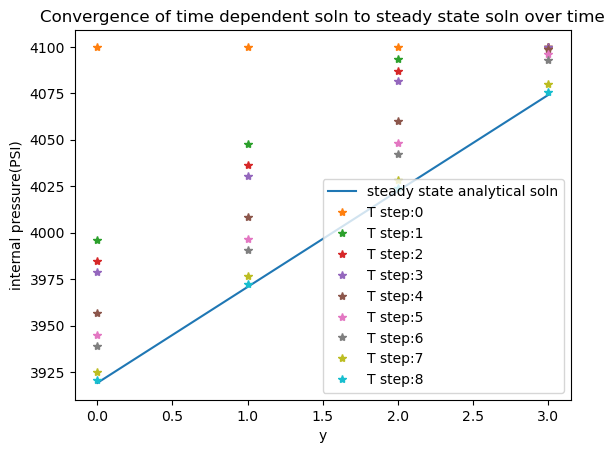

In [9]:
# extra: Prove that the time dependent soln converges to steady state soln 
# and estimate how long the pressure wave takes to reach the edge of reservoir
# with the given input parameters

print(f'Estimate of the pressure wave to reach the outer border ',
     f'{model.re_**2/4/model.eta:0.2f} secs',
     f'={model.re_**2/4/model.eta/60/60:0.2f} hours',
     f'={model.re_**2/4/model.eta/60/60/24:0.2f} days')

# plots to show that the internal pressures converge 
# to steady state solution on a long enough time scale

deltaTs = [0.001,0.001,0.001,0.01,0.02,0.03,0.4,0.5]
#print(deltaTs)
wp = model.wellperssure(deltaTs)
ps = model.internal_pressure_/model.psi_to_pa_
analytical = model.analytical_steadystate(model.y)/model.psi_to_pa_
fig,ax = plt.subplots()
ax.plot(analytical,'',label = 'steady state analytical soln')
for i, p in enumerate(ps[::]):
    ax.plot(p, '*', label= f'T step:{i}')
ax.set(xlabel='y',ylabel='internal pressure(PSI)')
plt.title('Convergence of time dependent soln to steady state soln over time')
plt.legend()

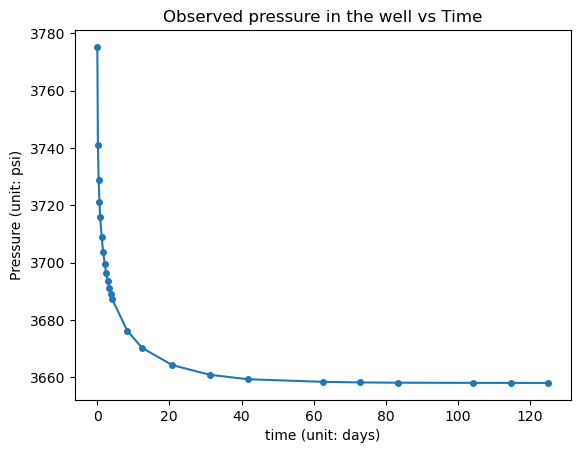

In [15]:
# read well bhp data and plot
df = pd.read_csv('./data/well_bhp.dat', delimiter ='\t')
df.time = df.time/24  # since we want to work with days we convert the time to days by dividint by 24

plt.plot(df.time, df.well_pressure, '-o', markersize=4)
plt.title('Observed pressure in the well vs Time')
#plt.xscale('log')
plt.xlabel('time (unit: days)')
plt.ylabel('Pressure (unit: psi)')
plt.savefig('Observeddata.png')

In [16]:
# fitting our model to the well BHP data

# simulation time of the well bhp 
# we add a 0th time step
# unit is in hours so we convert it to days by dividing by 24
simtim = np.append([0], df.time.to_numpy()) 

# well pressure
p_well_real = df.well_pressure.to_numpy()  

#find deltaTs, simulation time steps
deltaTs = simtim[1:]-simtim[:-1]

# To minimize truncation error during computation we take a 
# large value of N to fit the model
# Note: for N >150 curve_fit produces completely wrong results.
# not really sure why this happens, will investigate later

N=120   # a sufficiently small grid size

def func(deltaTs,re,pinit,k):
    '''
    function that we will try to curvefit
    
    params: deltaTs - time steps(in days)
    params: re, pinit, k are the physical parameter
    returns: well pressure (in psi)
    
    the curve_fit method will try to change the parameters 
    re, pinit, k till it reaches some values that produces 
    the least amount of error.
    '''
    model = PressureSolver(N, re=re,k=k,pinit=pinit )
    return(model.wellperssure(deltaTs))

xdata = deltaTs     # given a time discretization deltaTs
ydata = p_well_real # change re,pinit,k till you reach this value
# popt is the values of re,pinit,k reached
popt, pcov = curve_fit(func, xdata, ydata,maxfev = 80000) 

In [17]:
re,pinit,k = popt
print(f'Fitted parameters for our numeric model with {N} cells:: re={re:0.2f}ft, k={k:0.2f}mD, pinit={pinit:0.2f}psi')

Fitted parameters for our numeric model with 120 cells:: re=7805.20ft, k=378.49mD, pinit=4000.88psi


In [18]:
# now that we arrived at the re,pinit,k for the well BHP 
# we make the model with these parameters,

# create models with 'real' physical parameter
model = PressureSolver(N,re=re,k=k,pinit=pinit)
# find the numeric solution for well pressure taking the deltaTs from well BHP data
numerical = model.wellperssure(deltaTs)  
# lines source solution 
liness = model.line_source_soln(r=model.rw_, t=model.simtime_[1:])

In [25]:
print(f'Estimate of the pressure wave to reach the outer border ',
     f'{model.re_**2/4/model.eta:0.2f} secs',
     f'={model.re_**2/4/model.eta/60/60:0.2f} hours',
     f'={model.re_**2/4/model.eta/60/60/24:0.2f} days')

Estimate of the pressure wave to reach the outer border  1071304.09 secs =297.58 hours =12.40 days


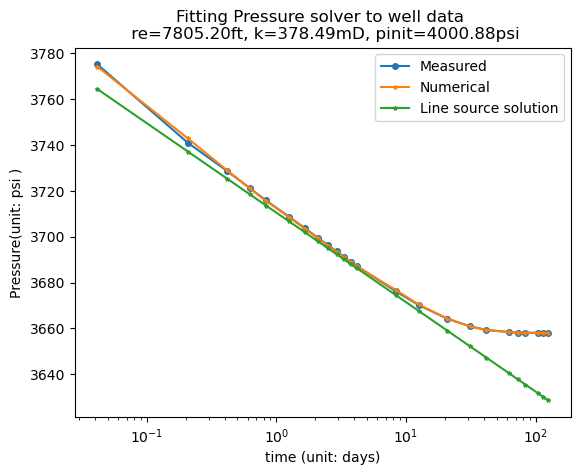

In [20]:
# Comparision plots for modelled (numerical) against 
# measured pressure values and line source solution

plt.plot(df.time, df.well_pressure, '-o', markersize=4, label='Measured')
plt.plot(df.time, numerical,'-*', markersize=3, label='Numerical')
plt.plot(df.time, liness,'-*', markersize=3, label='Line source solution')
plt.title(f'Fitting Pressure solver to well data \n re={re:0.2f}ft, k={k:0.2f}mD, pinit={pinit:0.2f}psi')
plt.xscale('log')
plt.xlabel('time (unit: days)')
plt.ylabel('Pressure(unit: psi )')
plt.legend()
plt.savefig('modelfitting.png')

In [21]:
# computing the volume of the reservior 
# lets assume the reservior is cylindrical in shape
Vres = np.pi*model.re_**2*model.h_
# water can only be present in the void of the rock, 
# so we multiply by porosity 
Vwater = Vres*model.phi_  
print(f'radius of the reservoir = {model.re_:.2f}m')
print(f'height of the reservoir = {model.h_:.2f}m')
print(f'porosity of the reservoir = {model.phi_}')
print(f'Bulk volume of reservoir is {Vres:.1f}m^3')
print(f'volume of water in the reservoir is {Vwater:.1f}m^3')

radius of the well = 2379.02m
height of the well = 3.35m
porosity of the well = 0.25
volume of reservoir is 59614925.0m^3
volume of water in the reservoir is 14903731.3m^3


# Exercise 3: Accuracy and performance of time dependent solution (BONUS)

For several values of N, compare your numerical solver implementation
to the line-source solution given by equation (27). To do the comparison,
you need to plot your solution in terms of the physical coordinates, i.e.,
$r(y) = r_we^y.$

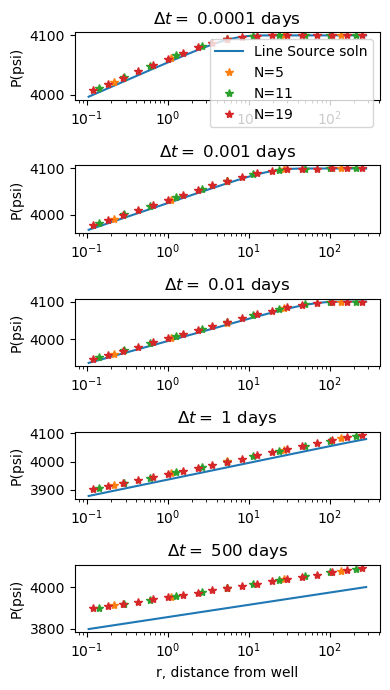

In [22]:
# For comparision between we will advance the clock by a deltaT
# and compute the numeric soln for a range of N
#


deltaTs = [0.0001,0.001,0.01,1,500]  # unit days

fig, axs = plt.subplots(nrows=len(deltaTs), figsize=(4,7))

for i,deltaT in enumerate(deltaTs):
    ax = axs[i]
    # for line solution is analytical, so its independent of the discretization
    # so for r we take some arbirary nodes, N=50 here
    model = PressureSolver(N=50)  # initiate model with 50 nodes
    r = model.r  # extra the r values (in m)
    # convert time to SI units
    # and find the line source solution at deltaT
    pressure_liness = model.line_source_soln(r, deltaT*model.day_to_sec_)
    ax.plot(r, pressure_liness, label='Line Source soln')

    Ns = [5, 11, 19]
    for N in Ns:
        # create model
        model = PressureSolver(N)
        # run time simulation in the model with deltaTs
        # in this sim there is only one time step
        _, internal_pressure = model.timedomainsim([deltaT])

        # radius to plot
        r = model.r
        # we are only interested in the pressure at the last time step
        p = internal_pressure[-1]

        ax.plot(r, p, '*', label=f'N={N}')

    ax.set(xscale='log',
           title=f'$\Delta t =$ {deltaT} days',
           ylabel='P(psi)',
           )


axs[0].legend()
axs[-1].set_xlabel('r, distance from well')
plt.tight_layout()
plt.savefig('linesource_default.png')
    # ax.set_yscale('log')
    #plt.legend(),

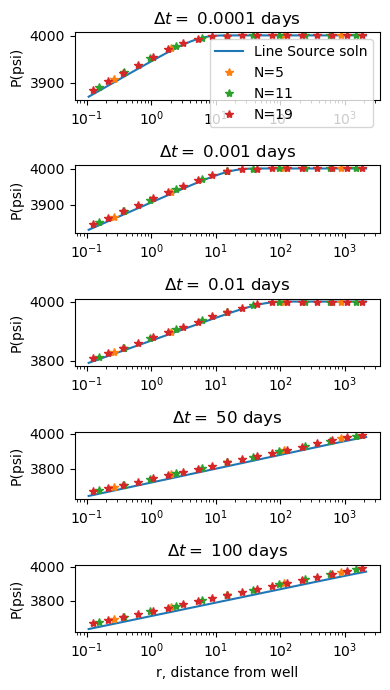

In [28]:
# For comparision between we will advance the clock by a deltaT
# and compute the numeric soln for a range of N
#


deltaTs = [0.0001,0.001,0.01,50,100]  # unit days

fig, axs = plt.subplots(nrows=len(deltaTs), figsize=(4,7))

for i,deltaT in enumerate(deltaTs):
    ax = axs[i]
    # for line solution is analytical, so its independent of the discretization
    # so for r we take some arbirary nodes, N=50 here
    model = PressureSolver(N=50,re=re,k=k,pinit=pinit)  # initiate model with 50 nodes
    r = model.r  # extra the r values (in m)
    # convert time to SI units
    # and find the line source solution at deltaT
    pressure_liness = model.line_source_soln(r, deltaT*model.day_to_sec_)
    ax.plot(r, pressure_liness, label='Line Source soln')

    Ns = [5, 11, 19]
    for N in Ns:
        # create model
        model = PressureSolver(N,re=re,k=k,pinit=pinit)
        # run time simulation in the model with deltaTs
        # in this sim there is only one time step
        _, internal_pressure = model.timedomainsim([deltaT])

        # radius to plot
        r = model.r
        # we are only interested in the pressure at the last time step
        p = internal_pressure[-1]

        ax.plot(r, p, '*', label=f'N={N}')

    ax.set(xscale='log',
           title=f'$\Delta t =$ {deltaT} days',
           ylabel='P(psi)',
           )


axs[0].legend()
axs[-1].set_xlabel('r, distance from well')
plt.tight_layout()
plt.savefig('linesource_real.png')

In [18]:
# test which algorith is the fastest
# make a model with N nodes
# solvers can take the values 
# 'numpy' for dense, 'scipy' for sparce and 'thomas_the_tank' for Thomas algorithm 

N = 100#_000
deltaT = 10

model = PressureSolver(N)
pn = np.ones(N)*model.pinit_

In [23]:
%%timeit
solver = 'thomas_the_tank'
a = model.solve_timedep(deltaT, pn, solver=solver)

47.4 µs ± 188 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
%%timeit
solver = 'scipy'
a = model.solve_timedep(deltaT, pn, solver=solver)

307 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
%%timeit
solver = 'numpy'
model.solve_timedep(deltaT, pn, solver='numpy')

90.6 µs ± 702 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Speed comparision
|    N|     numpy|         scipy| Thomas algo|
| --- | --- | --- | ---|
|    10|    20.4$\mu$s|    178$\mu$s| 23.3 $\mu$s|
|    100|   83$\mu$s|      310$\mu$s| 47.8$\mu$s|
|    1000|  23.6 ms|          10.1 ms|      3.61 ms|
|   5000|  1.86 s|       0.97 s|        1.03s| 
|    10000| 8 s|          3.4 s|        4.1s| 
|20000 |  - | 14.9s|15.5s|